<a href="https://colab.research.google.com/github/anatomiefemale/Boulangerie/blob/main/CNN_for_Histology_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Necessary Libraries**

In [2]:
import os
import random
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report,confusion_matrix

#We will be using Keras to build our CNN.
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2

np.random.seed(22)

**Mount Google Collab in order to access the data**

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Create two python definitions to read in our normal data and our invasive data.**

In [18]:
def load_normal(norm_path):
    norm_files = np.array(os.listdir(norm_path)) #Obtain all the normal images.
    norm_labels = np.array(['normal']*len(norm_files)) #Create a list of labels (1's) for all the normal images.

    norm_images = []
    for image_name in tqdm(norm_files):
        image_path = os.path.join(norm_path, image_name)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Skipping file {image_name}, can't be read.")
            continue
        image = cv2.resize(image, dsize=(200,200))
        norm_images.append(image)

    norm_images = np.array(norm_images)

    return norm_images, norm_labels

def load_invasive(inv_path):
    inv_files = np.array(os.listdir(inv_path))
    inv_labels = np.array(['invasive']*len(inv_files)) #Create a list of labels (1's) for all the invasive images.

    inv_images = []
    for image in tqdm(inv_files):
        image = cv2.imread(inv_path + image)
        image = cv2.resize(image, dsize=(200,200))
        inv_images.append(image)

    inv_images = np.array(inv_images)

    return inv_images, inv_labels

In [15]:
#Explore the contents of your directory to ensure you are in the right location.

#os.listdir('/content/drive/MyDrive/Normal')

In [19]:
norm_images_train, norm_labels_train = load_normal('/content/drive/MyDrive/Normal')

100%|██████████| 100/100 [00:42<00:00,  2.33it/s]


In [53]:
print(len(norm_images_train)) #This is a list of arrays, where each array represents the pixels in one image. Note: each image is 200 x 200
print(norm_images_train[0].shape) #We can see here that image one is indeed size 200 by 200


100
(200, 200, 3)


In [22]:
inv_images_train, inv_labels_train = load_invasive('/content/drive/My Drive/Invasive/')

100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


In [54]:
print(len(inv_images_train))
print(inv_images_train[0].shape)

100
(200, 200, 3)


**Create training and test data. Here, we do a 70/30% split.**

In [23]:
trainNormal=norm_images_train[0:70]

In [25]:
testNormal=norm_images_train[70:]

In [27]:
trainInvasive=inv_images_train[0:70]

In [28]:
testInvasive=inv_images_train[70:]

In [29]:
X_train=np.append(trainNormal, trainInvasive, axis=0)
y_train=np.append(norm_labels_train[0:70], inv_labels_train[0:70])

In [30]:
X_train.shape
#There are 140 training images (70 normal images and 70 invaive images)
#Each of these images are sizes 200 by 200
#Each of these images, if in color, are described by RGB color channels hence the '3'.

(140, 200, 200, 3)

**Let's check our data to see what a batch of it looks like.**

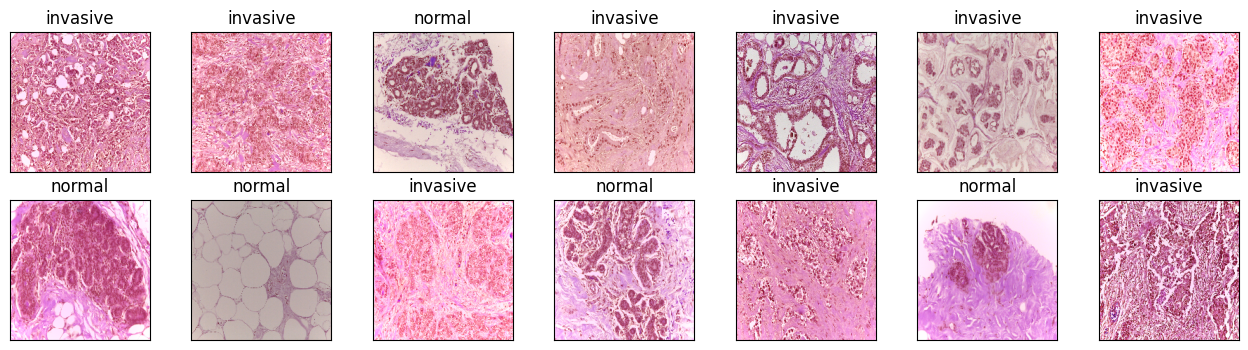

In [31]:
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(16, 4))

indices = np.random.choice(len(X_train), 14)
counter = 0

for i in range(2):
    for j in range(7):
        axes[i,j].set_title(y_train[indices[counter]])
        axes[i,j].imshow(X_train[indices[counter]], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        counter += 1
plt.show()

In [32]:
X_test=np.append(testNormal, testInvasive, axis=0)
y_test=np.append(norm_labels_train[70:], inv_labels_train[70:])

* Here we apply the OneHotEncoder from sklearn to transform y_train and y_test into one-hot encoded arrays. This means for each label in y_train and y_test, the encoder creates a binary column for each category and returns a matrix with 1s and 0s, indicating the presence of each category.
* The sparse=False argument makes the output a dense numpy array instead of a sparse matrix. This is commonly used in machine learning models to handle categorical data.
* In image classification, especially with neural networks, the output layer typically uses a softmax function to predict the probability distribution across different classes. One-hot encoding transforms categorical labels into a binary matrix that matches this output structure, making it easier for the model to compute loss (like cross-entropy loss) and optimize its weights during training, leading to more effective learning.















In [33]:
y_train=y_train[:, np.newaxis]
y_test=y_test[:, np.newaxis]
one_hot_encoder=OneHotEncoder(sparse=False)
y_train_one_hot=one_hot_encoder.fit_transform(y_train) #This will provide us with a transformed response.
y_test_one_hot=one_hot_encoder.fit_transform(y_test) #This will provide us with a transformed response.

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [34]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 3)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 3)

* Here we initialize an ImageDataGenerator with specific transformations to augment image data during training.
* It applies random rotations (up to 10 degrees), zooms (up to 10%), and shifts in both width and height (up to 10%).
* These augmentations introduce variability, mimicking different perspectives, sizes, and positions of objects within images, which helps improve the model's generalization and robustness by training it on more diverse data.
* datagen.fit(X_train) computes the necessary internal data statistics needed for data augmentation, such as mean and standard deviation, which are used for feature-wise normalization.
* train_gen = datagen.flow(X_train, y_train_one_hot, batch_size = 32) creates an iterator that generates batches of image data with labels after applying the specified augmentations. Each batch will contain 32 images and their corresponding one-hot encoded labels, ready to be used for training the model.















In [35]:
datagen = ImageDataGenerator(
        rotation_range = 10,
        zoom_range = 0.1,
        width_shift_range = 0.1,
        height_shift_range = 0.1)

datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train_one_hot, batch_size = 32)

**Define a simple CNN model with a few convolutional layers followed by max pooling layers. Here, a drop out layer is added to help avoid overfitting.**

Why a CCN? Why not an ANN?

Convolutional neural networks take advantage of the spacial locality inherent in images, whereas fully connected networks flatten the image and effectively permute the pixels randomly. Ever tried to look at an image flattened into an array with the pixels randomly permuted? Not easy. Nor is it for a neural network.

Note: The filters in the first layer of the CNN must match the number of channels in the input, since it learns different features from different channels.

In [37]:
#Notice that the model generated in the next cell is significantly more accurate and generalizable than the model generated here.
"""
model = Sequential() #Initiate the sequential model.
model.add(Convolution2D(200, 3, 3, activation='relu', input_shape=(200, 200, 3)))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))   # since 2 classes
"""

* This code defines a Sequential neural network model for binary image classification.
* It starts with two convolutional layers (Conv2D) with 32 and 64 filters, each followed by batch normalization, max pooling to reduce spatial dimensions, and dropout to prevent overfitting.
* After flattening the convolved features, the model includes a fully connected layer with 64 units and L2 regularization, another batch normalization layer, and a final dropout layer.
* The output layer uses softmax activation for binary classification, indicating the model's prediction of two possible classes.








In [48]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))  # Assuming binary classification


**Compile the model using Adam as the optimizer and sparse categorical crossentropy as the loss function.**

In [49]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

**Train the model for several epochs.**

In [50]:
history=model.fit(train_gen, epochs=10, validation_data=(X_test, y_test_one_hot))

Epoch 1/10
5/5 [==============================] - 20s 4s/step - loss: 2.2635 - accuracy: 0.7286 - val_loss: 63.8391 - val_accuracy: 0.5000
Epoch 2/10
5/5 [==============================] - 15s 3s/step - loss: 2.6276 - accuracy: 0.8143 - val_loss: 3.5779 - val_accuracy: 0.8833
Epoch 3/10
5/5 [==============================] - 16s 3s/step - loss: 2.9439 - accuracy: 0.8143 - val_loss: 6.6677 - val_accuracy: 0.6667
Epoch 4/10
5/5 [==============================] - 15s 3s/step - loss: 3.1715 - accuracy: 0.8286 - val_loss: 5.3406 - val_accuracy: 0.6500
Epoch 5/10
5/5 [==============================] - 15s 3s/step - loss: 3.1276 - accuracy: 0.8214 - val_loss: 3.8803 - val_accuracy: 0.7667
Epoch 6/10
5/5 [==============================] - 15s 3s/step - loss: 2.9957 - accuracy: 0.8286 - val_loss: 4.0631 - val_accuracy: 0.6667
Epoch 7/10
5/5 [==============================] - 15s 3s/step - loss: 2.8679 - accuracy: 0.8214 - val_loss: 3.7568 - val_accuracy: 0.6667
Epoch 8/10
5/5 [=================

**Evaluate the result by plotting the training and validation accuracy along with training and validation loss.**

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

**Let's see what the curve looks like. Accuracy and loss are on the y-axis, and epochs are on the x-axis.**

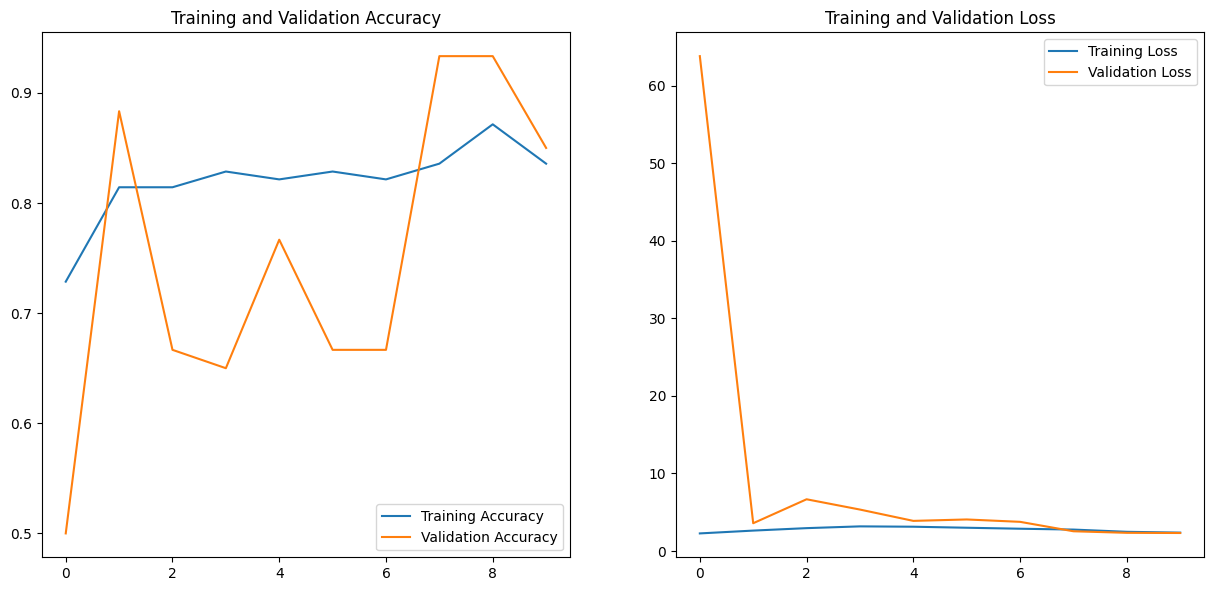

In [52]:
epochs_range = range(10)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()